### Transfer Learnig (전이 학습)

In [1]:
# Pandas and Bearsclassification model with InceptionV3
# train : 500 images [Bears(250) + Panda(250)]  , size : 256*256
# validation : 100 images [Bears(50) + Panda(50)], size: 256*256

In [2]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
# Google InceptionV3 pretrained model 가중치 다운로드, Windows용
_INCEPTION_URL = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
urllib.request.urlretrieve(_INCEPTION_URL, 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

('tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x1bb5d4585b0>)

In [4]:
# 사전 훈련된 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (256,256,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# 사전 훈련 계층의 가중치의 훈련(학습) 가능 여부를 설정 : False(학습 안함)
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

# 마지막 층 출력 확인하기
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape) # (None, 7, 7, 768)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [5]:
# 모델구성/컴파일
# Flatten Layer
x = layers.Flatten()(last_output)  # (None,37632)
# Dense Layer : Hidden Layer
x = layers.Dense(1024,activation='relu')(x)  # (None,1024)
# Dropout Layer : 0.2
x = layers.Dropout(0.2)(x)
# Dense Layer : Final Output Layer, sigmoid
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
len(pre_trained_model.layers)  # 311개 layers   (top 2개 제외)

311

### 이미지 증강(Image Augmentation)

In [7]:
# # cats_and_dogs 데이터셋 다운로드 , Windows용
# _TRAIN_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
# urllib.request.urlretrieve(_TRAIN_URL, 'tmp/cats_and_dogs_filtered.zip')

In [8]:
# # 압축해제
# local_zip = 'tmp/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('tmp/')
# zip_ref.close()

In [14]:
# 이미지 데이터 경로 설정
import os

base_dir = 'tmp/PandasBears'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

# Directory with our training bears/pandas pictures
train_bears_dir = os.path.join(train_dir, 'Bears')
train_pandas_dir = os.path.join(train_dir, 'Pandas')

# Directory with our validation bears/pandas pictures
validation_bears_dir = os.path.join(validation_dir, 'Bears')
validation_pandas_dir = os.path.join(validation_dir, 'Pandas')

train_bears_fnames = os.listdir( train_bears_dir )
train_pandas_fnames = os.listdir( train_pandas_dir )

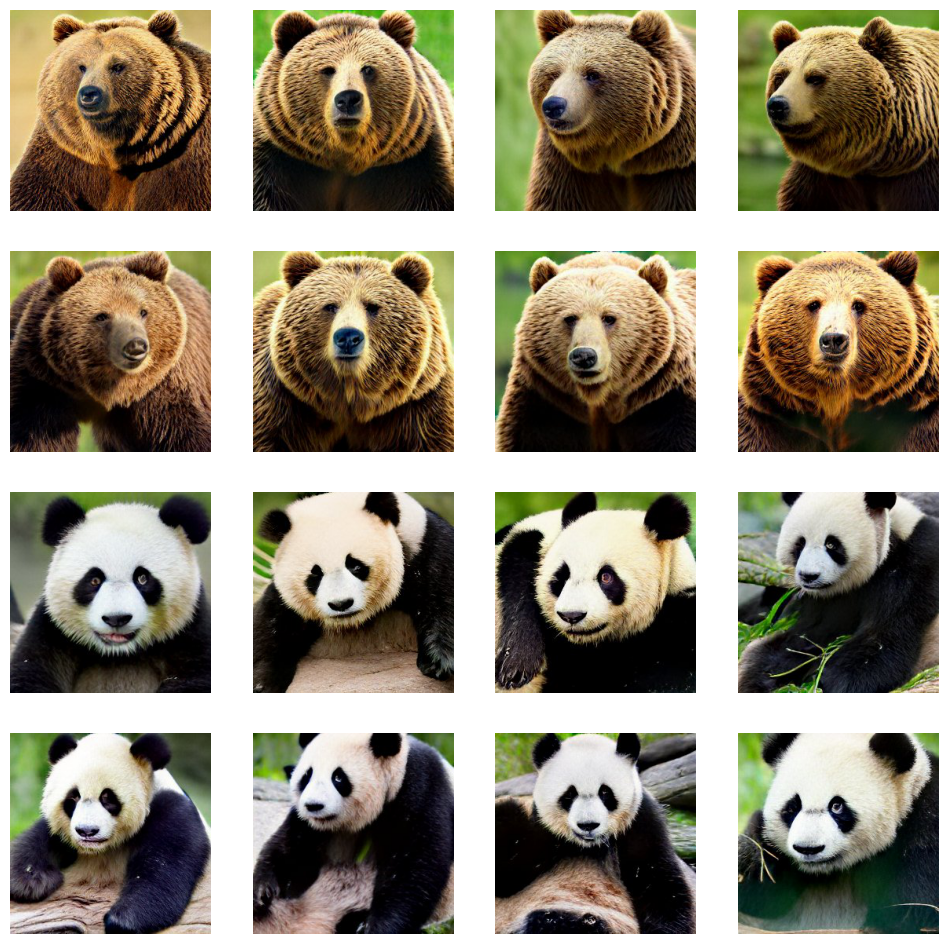

In [15]:
# 데이터 시각화
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images ,시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_bears_pix = [os.path.join(train_bears_dir, fname) 
                for fname in train_bears_fnames[ pic_index-8:pic_index] 
               ]

next_pandas_pix = [os.path.join(train_pandas_dir, fname) 
                for fname in train_pandas_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_bears_pix+next_pandas_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [10]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(256, 256),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='binary')


Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [11]:
# 학습 : GPU ,약 06분 소요
# 사전 훈련 가중치는 업데이트 하지 않고 추가 계층만 가중치 업데이트하여 학습
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 13,   # 250/20
            epochs = 20,
            validation_steps = 3,   # 50/20
            verbose = 1)

Epoch 1/20
13/13 [==============================] - 14s 431ms/step - loss: 0.7575 - accuracy: 0.8538 - val_loss: 3.5478e-05 - val_accuracy: 1.0000
Epoch 2/20
13/13 [==============================] - 4s 331ms/step - loss: 9.3514e-04 - accuracy: 1.0000 - val_loss: 2.8519e-05 - val_accuracy: 1.0000
Epoch 3/20
13/13 [==============================] - 4s 336ms/step - loss: 1.9987e-04 - accuracy: 1.0000 - val_loss: 1.5696e-05 - val_accuracy: 1.0000
Epoch 4/20
13/13 [==============================] - 4s 325ms/step - loss: 5.9238e-04 - accuracy: 1.0000 - val_loss: 3.9700e-05 - val_accuracy: 1.0000
Epoch 5/20
13/13 [==============================] - 4s 336ms/step - loss: 1.2671e-04 - accuracy: 1.0000 - val_loss: 1.4486e-05 - val_accuracy: 1.0000
Epoch 6/20
13/13 [==============================] - 4s 328ms/step - loss: 4.2615e-05 - accuracy: 1.0000 - val_loss: 5.0011e-06 - val_accuracy: 1.0000
Epoch 7/20
13/13 [==============================] - 4s 336ms/step - loss: 1.5828e-05 - accuracy: 1.0000

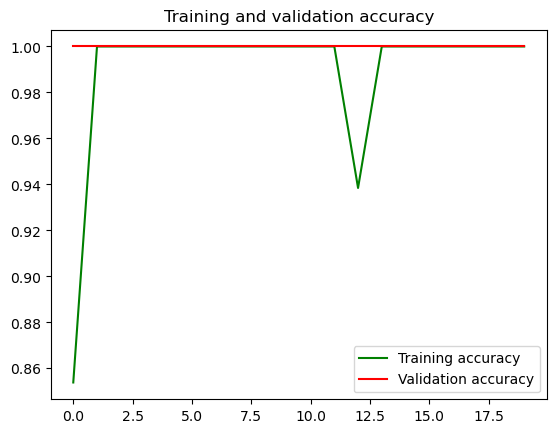

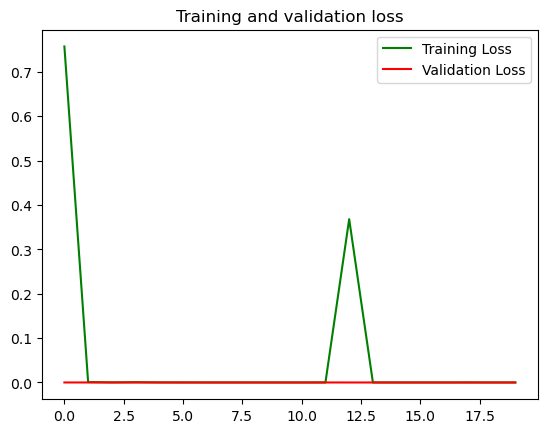

In [12]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()